# Laboratory No. 2. Statistical Inference
# Excercise 5:
# Bayesian Probabilistic Principal Component Analysis(BPPCA)
### presented by: Juan David Gil and Juan Sebastián Silva
### Date: 29 february 2016

In [1]:
% pylab inline
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pylab as pb
from matplotlib import cm

Populating the interactive namespace from numpy and matplotlib


First the data is loaded from the files

In [3]:
digits = []
for i in range(0,9):
    file_name = "../digit" + str(i) + ".csv"
    X = np.loadtxt(open(file_name,"rb"),delimiter=",")
    digits.append(X)

In order to avoid numerical problems the data is normalized first.

In [4]:
# Normalizing Data
for i in range(0,9):
    X = digits[i]
    for j in range(0,X.shape[0]):
        for k in range(0,X.shape[1]):
            X[j,k] = X[j,k]/255.0 # normalizing by the maximum value of the image
    digits[i] = X
#print digits[0][0,:]

In [70]:
# Expectation maximization algorithm
# input: Data, dimensions and latent space dimensions
# output: Projection matrix, sigma, Expected value of z and sample mean
def PPCA(XX, D, M=10):
    Qold = 0.0
    Qnew = 1.0
    EPS = 0.00001
    W_estim = np.random.random_sample((D,M))
    W_estim = np.matrix(W_estim)
    alpha_weight = np.zeros(M)
    XX = np.matrix(XX)
    sigma_estim = 10.0
    cont = 0
    N = XX.shape[0]
    sample_mean = np.sum(XX, axis=0) # Sample mean
    sample_mean = sample_mean*(1.0/N) # sample mean
    
    #print sample_mean
    covariances = []
    for i in range(0,N):
        tmp = np.zeros((M,M))
        tmp = np.matrix(tmp)
        covariances.append(tmp)

    m1 = np.copy(XX)
    m1 = np.matrix(m1)
    m1_norm = np.zeros((XX.shape[0],1))
    m1_norm = np.matrix(m1_norm)

    # Computing the squared norm of X - sample mean
    for i in range(0, XX.shape[0]):
        m1[i,:] = m1[i,:] - sample_mean
        m1_norm[i,0] = np.asscalar(m1[i,:]*m1[i,:].T) 

    super_exp_z = 0
    #mostrar = np.copy(XX[300,:])
    while(np.fabs(Qold - Qnew) >= EPS and cont <= 200):
        # Compute the expected values
        for i in range(0, W_estim.shape[1]):
            alpha_weight[i] = D/(np.dot(W_estim[:,i].T, W_estim[:,i]))
            
        A = np.diag(alpha_weight)*sigma_estim
        M_tmp = W_estim.T*W_estim + sigma_estim*np.eye(M) 
        exp_z = (np.linalg.inv(M_tmp)*W_estim.T)*(m1.T)
        super_exp_z = np.copy(exp_z)
        for i in range(0,N):        
            tmp_cov = ((sigma_estim)*np.linalg.inv(M_tmp)) + np.outer(exp_z[:,i],exp_z[:,i].T)
            covariances[i] = tmp_cov        

        # Update parameters   
        #     W estimation   
        W_estim = (m1.T*exp_z.T)
        super_cov_z = covariances[0]    
        for i in range(1,N):
            super_cov_z += covariances[i]

        W_estim = W_estim*np.linalg.inv(super_cov_z + A)    
        #     Sigma Estimation
        sigma_estim = 0.0
        for i in range(0,N):         
            sigma_estim += m1_norm[i,0] - np.asscalar((2.0*(exp_z[:,i].T*W_estim.T*m1[i,:].T))) + np.trace(covariances[i]*W_estim.T*W_estim)        
        sigma_estim *= (1.0/(N*D))
        cont += 1

    return W_estim, sigma_estim, super_exp_z, sample_mean, alpha_weight

In [78]:
def evalReconstruction(W_estim, sigma_estim, sample_mean, digits, des_digit=0):
    XX = np.matrix(digits[des_digit])
    m1 = np.copy(XX)
    m1 = np.matrix(m1)
    for i in range(0, XX.shape[0]):
        m1[i,:] = m1[i,:] - sample_mean
    
    M_tmp = W_estim.T*W_estim + sigma_estim*np.eye(W_estim.shape[1])    
    super_exp_z = (np.linalg.inv(M_tmp)*W_estim.T)*(m1.T)
    
    X_rec = W_estim*super_exp_z #+ np.sqrt(sigma_estim)
    for i in range(0,X_rec.shape[1]):
        X_rec[:,i] = X_rec[:,i] + sample_mean.T

    X_rec = X_rec.T
    X_real = digits[des_digit]
    SSD = 0.0
    for i in range(0, X_rec.shape[0]):
        diff = X_rec[i,:] - X_real[i,:]
        diff = diff*diff.T
        SSD += asscalar(diff)
    
    Z_Rec = X_rec[300,:]
    Z_Rec = Z_Rec.reshape((28,28))    
    return Z_Rec, SSD/X_rec.shape[0]

In [82]:
np.random.seed(2)
W_estim, sigma_estim, super_exp_z, sample_mean, alpha_weight = PPCA(digits[3], digits[3].shape[1], 10)

###For testing the PCA a databse of digits will be used, two digits will be chosen to apply the PCA, in this case the digit tree and digit five

## Recovering Digit 3 with several latent space dimensions

------------------------------------------------------------------------------
reconstruction error for first M=1 less weighted subspace vectors 43.4820365397
reconstruction error for M=1 most weighted subspace vectors 43.2260062443
------------------------------------------------------------------------------
reconstruction error for first M=3 less weighted subspace vectors 35.3901191445
reconstruction error for M=3 most weighted subspace vectors 40.4262139305
------------------------------------------------------------------------------
reconstruction error for first M=5 less weighted subspace vectors 30.7819452591
reconstruction error for M=5 most weighted subspace vectors 33.1483739209


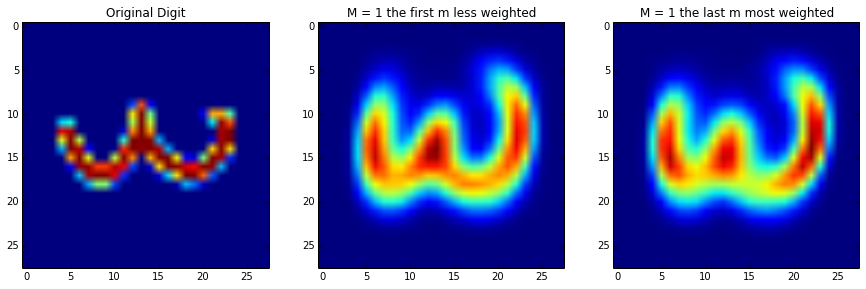

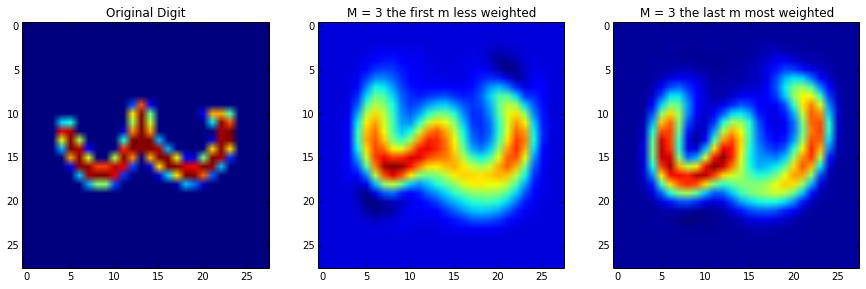

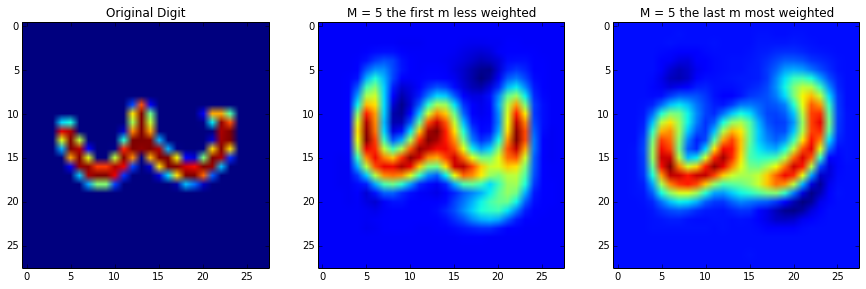

In [83]:
digit_to_use = 3
cont = 1
amount_of_test = 2
M_val = [1,3,5]
for m in M_val:
    plt.figure(cont, figsize=(15,6))
    plt.subplot(1,3,1)
    plt.title('Original Digit')
    plt.imshow(digits[digit_to_use][300,:].reshape(28,28))
    a = np.arange(alpha_weight.shape[0])
    tmp_arr = []
    for i in range(0,alpha_weight.shape[0]):
        tmp_arr.append((alpha_weight[i], a[i]))
    tmp_arr.sort()
    idx = np.zeros(alpha_weight.shape[0], dtype=bool)
    idx[0:m] = True        
    sub_w = W_estim[:,idx]
    z_rec, error_ssd = evalReconstruction(sub_w, sigma_estim, sample_mean, digits, digit_to_use)
    print'------------------------------------------------------------------------------'
    print 'reconstruction error for first M=' +str(m)+' less weighted subspace vectors', error_ssd
    cont += 1
    plt.subplot(1,3,2)
    plt.title('M = ' + str(m) + ' the first m less weighted')
    plt.imshow(z_rec)
    
    idx = np.zeros(alpha_weight.shape[0], dtype=bool)
    idx[alpha_weight.shape[0] - m:alpha_weight.shape[0]] = True        
    sub_w = W_estim[:,idx]
    z_rec, error_ssd = evalReconstruction(sub_w, sigma_estim, sample_mean, digits, digit_to_use)
    print 'reconstruction error for M=' +str(m)+' most weighted subspace vectors', error_ssd
    cont += 1
    plt.subplot(1,3,3)
    plt.title('M = ' + str(m) + ' the last m most weighted')
    plt.imshow(z_rec)

The test showed above takes an especific digit after training and makes the reconstruction in two ways, first the less M weighted subspace vectors are taken, then the most M weighted vectors, after that a projection and reprojection of that point is made in both ways to demonstrate that the reconstruction is less accurate when the most weighted column vectors form W are taken, in the reconstruction error one can see that fact, the reconstruction error is less when the less weighted column vectors from W are taken.

For this test the reconstruction was made setting a latent space dimention of 10, using all the dimension of data was very time consuming. In the ideal testing scheme a run of the algorithm must be made but assuming that M=D(the dimension of latent space could be as big as the real space), the bayesian PPCA will determine the real value of M given the weights for each column vector in W.